# Automated ML

In [1]:
from azureml.core import Experiment, Dataset, Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice

import pandas as pd
import logging

In [3]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-experiment'

experiment=Experiment(ws, experiment_name)

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code RWMUZ4DKH to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


## Attrition Dataset

### Overview

This is a fictional dataset made by the IBM data scientists to find relations between dependent and independent variables. The prediction task consist in detect the factors that lead to employee attrition.

In [4]:
# data_path = "https://raw.githubusercontent.com/jaircastruita/nd00333-capstone/master/starter_file/data/WA_Fn-UseC_-HR-Employee-Attrition.csv"
# ibm_ds = Dataset.Tabular.from_delimited_files(path=data_path)

ibm_ds = Dataset.get_by_name(ws, 'attrition-dataset')

In [5]:
ibm_ds.to_pandas_dataframe().head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Creating a compute instance

In [6]:
cluster_name = "automl-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Reusing already created cluster: {}".format(cluster_name))

except ComputeTargetException:
    print("Creating a new compute cluster...")
    cluster_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=5)
    compute_target = ComputeTarget.create(workspace=ws, name=cluster_name, provisioning_configuration=cluster_config)

compute_target.wait_for_completion(show_output=True)

Creating a new compute cluster...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

Given the nature of the selected dataset: tabular, with categorical and numeric columns, relatively few observations with relatively many columns, the following settings were selected in the automl configuration:

- *iteration_timeout_minutes* to 30, just to make sure the experiment will finish in a feasible time
- *enable_early_stopping* to True in order to not waste resources when the model performance is not improving
- *primary_metric* "AUC_weighted" given we are facing an umbalanced dataset problem
- *verbosity* logging.INFO to capture important events for the model experiments
- *max_concurrent_iterations* to 5 in order to parallelize experimentation
- *n_cross_validations* to 5 to give an estimated 80-20 proportion to the training-testing sets in each fold
- *task* will be "classification" because the objective is to identify attrition as a "Yes", "No" labeling problem 

In [7]:
automl_settings = {"iteration_timeout_minutes": 30,
                    "enable_early_stopping": True,
                    "primary_metric": "AUC_weighted",
                    "verbosity": logging.INFO,
                    "max_concurrent_iterations": 5,
                    "n_cross_validations": 5
                    }

automl_config = AutoMLConfig(task="classification",
                             compute_target=compute_target,
                             training_data=ibm_ds,
                             label_column_name="Attrition",
                             **automl_settings)

In [8]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion(show_output=True)

Running on remote.
No run_configuration provided, running on automl-cluster with default configuration
Running on remote compute: automl-cluster
Parent Run ID: AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias tow

{'runId': 'AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e',
 'target': 'automl-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-02-19T21:55:29.1065Z',
 'endTimeUtc': '2021-02-19T22:29:50.569986Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'automl-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-experiment","subscription_id":"9e65f93e-bdd8-437b-b1e8-0647cd6098f7","resource_group":"aml-quickstarts-139183","workspace_name":"quick-starts-ws-139183","region":"southcentralus","compute_target":"automl-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"AUC_weighted","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"n

In [9]:
# from azureml.train.automl.run import AutoMLRun

# remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_087c6ad3-ea12-4397-aec0-abb21503bc96')

In [10]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-experiment,AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

In [11]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model



In [12]:
best_automl_run, best_automl_model = remote_run.get_output()

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


In [ ]:
best_automl_model.steps[1][1].estimators

In [13]:
print(best_automl_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                  min_weight_fraction_leaf=0.0,
                                                                                                  n_estimators=100,
                                                                                                  n_jobs=1,
                                        

In [14]:
best_automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-experiment,AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e_62,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [15]:
get_best_automl_metrics = best_automl_run.get_metrics()

for metric_name in get_best_automl_metrics:
    metric = get_best_automl_metrics[metric_name]
    print(metric_name, metric)

recall_score_macro 0.6544391248231879
matthews_correlation 0.4682894976601232
log_loss 0.3638084448547915
precision_score_macro 0.8624115608886221
average_precision_score_micro 0.9268823636734916
weighted_accuracy 0.9604198554687488
AUC_micro 0.9353001064371327
AUC_weighted 0.84267755042465
f1_score_micro 0.8775510204081632
average_precision_score_weighted 0.8987521365926515
precision_score_weighted 0.8744500921698514
recall_score_weighted 0.8775510204081632
norm_macro_recall 0.30887824964637584
f1_score_macro 0.6940534588255118
accuracy 0.8775510204081632
precision_score_micro 0.8775510204081632
balanced_accuracy 0.6544391248231879
f1_score_weighted 0.8529333888324526
recall_score_micro 0.8775510204081632
average_precision_score_macro 0.7878989981749115
AUC_macro 0.84267755042465
confusion_matrix aml://artifactId/ExperimentRun/dcid.AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e_62/confusion_matrix
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_f0166041-60b0-404f-bdd5-880e74fdb

View updated transformation summary

In [16]:
custom_featurizer = best_automl_model.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary(is_user_friendly=True)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Age,Categorical,No,43,[StringCast-CharGramCountVectorizer]
1,BusinessTravel,Categorical,No,3,[StringCast-CharGramCountVectorizer]
2,Department,Categorical,No,3,[StringCast-CharGramCountVectorizer]
3,DistanceFromHome,Categorical,No,29,[StringCast-CharGramCountVectorizer]
4,Education,Categorical,No,5,[StringCast-CharGramCountVectorizer]
5,EducationField,Categorical,No,6,[StringCast-CharGramCountVectorizer]
6,EnvironmentSatisfaction,Categorical,No,4,[StringCast-CharGramCountVectorizer]
7,Gender,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
8,JobInvolvement,Categorical,No,4,[StringCast-CharGramCountVectorizer]
9,JobLevel,Categorical,No,5,[StringCast-CharGramCountVectorizer]


In [17]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,Age,Categorical,No,43,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Age'], 'Transform..."
1,BusinessTravel,Categorical,No,3,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['BusinessTravel'],..."
2,Department,Categorical,No,3,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Department'], 'Tr..."
3,DistanceFromHome,Categorical,No,29,[StringCast-CharGramCountVectorizer],{'Transformer1': {'Input': ['DistanceFromHome'...
4,Education,Categorical,No,5,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Education'], 'Tra..."
5,EducationField,Categorical,No,6,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['EducationField'],..."
6,EnvironmentSatisfaction,Categorical,No,4,[StringCast-CharGramCountVectorizer],{'Transformer1': {'Input': ['EnvironmentSatisf...
7,Gender,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Gender'], 'Transf..."
8,JobInvolvement,Categorical,No,4,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['JobInvolvement'],..."
9,JobLevel,Categorical,No,5,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['JobLevel'], 'Tran..."


## Model explanation

In [21]:
from azureml.interpret import ExplanationClient

In [18]:
from azureml.core.run import Run

model_explainability_run_id = remote_run.id + "_" + "ModelExplain"
print(model_explainability_run_id)
model_explainability_run = Run(experiment=experiment, run_id= model_explainability_run_id)
model_explainability_run.wait_for_completion()

# get the best fitted model
best_run, fitted_model = remote_run.get_output()

AutoML_f0166041-60b0-404f-bdd5-880e74fdb44e_ModelExplain


Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


In [23]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'OverTime': 0.30062742381367397,
 'StockOptionLevel': 0.24703925404431035,
 'JobLevel': 0.20227149424030477,
 'JobRole': 0.13085451283088062,
 'YearsWithCurrManager': 0.12598004730265036,
 'JobSatisfaction': 0.12224713263094114,
 'EnvironmentSatisfaction': 0.12218218278306063,
 'MonthlyIncome': 0.09306574364839597,
 'BusinessTravel': 0.09119591416251104,
 'WorkLifeBalance': 0.06976388742663556,
 'Department': 0.06300627840515224,
 'RelationshipSatisfaction': 0.06137949879092114,
 'NumCompaniesWorked': 0.059544361281181214,
 'JobInvolvement': 0.05791328438091513,
 'YearsAtCompany': 0.056215543006235685,
 'EducationField': 0.053464062873238266,
 'MaritalStatus': 0.052213204932455175,
 'PercentSalaryHike': 0.04937514938277283,
 'YearsInCurrentRole': 0.0443063273433923,
 'DailyRate': 0.041911901891016144,
 'Age': 0.04116846489440599,
 'TrainingTimesLastYear': 0.03682256024259807,
 'TotalWorkingYears': 0.03631796060938037,
 'DistanceFromHome': 0.0355472534429109,
 'YearsSinceLastPromotion'

In [24]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'OverTime_ModeCatImputer_LabelEncoder': 0.30062742381367397,
 'StockOptionLevel_CharGramCountVectorizer_0': 0.20350925764084088,
 'JobLevel_CharGramCountVectorizer_1': 0.15575560881068023,
 'YearsWithCurrManager_CharGramCountVectorizer_0': 0.10666372279615224,
 'EnvironmentSatisfaction_CharGramCountVectorizer_1': 0.10329311896894094,
 'MonthlyIncome_MeanImputer': 0.09306574364839597,
 'BusinessTravel_CharGramCountVectorizer_travel_frequently': 0.06949139900695524,
 'JobSatisfaction_CharGramCountVectorizer_4': 0.06254735081048571,
 'JobSatisfaction_CharGramCountVectorizer_1': 0.05647672074948927,
 'RelationshipSatisfaction_CharGramCountVectorizer_1': 0.05123781203444644,
 'JobRole_CharGramCountVectorizer_sales executive': 0.048267783720710535,
 'WorkLifeBalance_CharGramCountVectorizer_3': 0.046981029212079306,
 'MaritalStatus_CharGramCountVectorizer_single': 0.04238175393218858,
 'DailyRate_MeanImputer': 0.041911901891016144,
 'JobRole_CharGramCountVectorizer_research scientist': 0.039

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [25]:
model_name = best_automl_run.properties["model_name"]
script_file_name = "inference/score.py"
best_automl_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [26]:
print(remote_run.model_id)

None


In [27]:
# Register the model to deploy
# model = run.register_model(model_name = "mymodel", model_path = "outputs/model.pkl")
description = 'sample service for Automl Classification'
model = best_automl_run.register_model(description = description,
                                       model_name=model_name,
                                       tags={'area': "Attrition", 'type': "automl_classification"},
                                       model_path = "outputs/model.pkl")

# Combine scoring script & environment in Inference configuration
inference_config = InferenceConfig(entry_script=script_file_name)

# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, 
                                                       memory_gb=1,
                                                       tags={'area': "AttritionData", 'type': "automl_classification"},
                                                       description=description)

# Define the model, inference, & deployment configuration and web service name and location to deploy
service = Model.deploy(
    workspace=ws,
    name="automl-web-service",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config)

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [29]:
# Enable application insights
service.update(enable_app_insights = True)

In [34]:
print("State : ", service.state)
# print("Key :", service.get_keys()[0])
print("Swagger URI : ", service.swagger_uri)
print("Scoring URI : ", service.scoring_uri)

State :  Healthy
Swagger URI :  http://684cb6fc-ab9c-4c8f-8032-654e904eb4f1.southcentralus.azurecontainer.io/swagger.json
Scoring URI :  http://684cb6fc-ab9c-4c8f-8032-654e904eb4f1.southcentralus.azurecontainer.io/score


## Test Deployed model

In [35]:
from numpy import array

In [36]:
X_test = ibm_ds.drop_columns(columns=['Attrition'])
y_test = ibm_ds.keep_columns(columns=['Attrition'], validate=True)

In [37]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [38]:
import json
import requests

X_test_json = X_test.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [39]:
actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

1470   1470


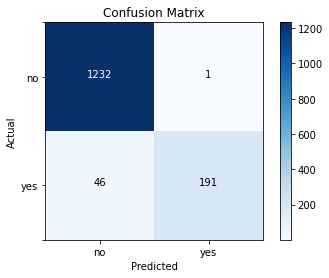

In [40]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

TODO: In the cell below, print the logs of the web service and delete the service

In [41]:
print(service.get_logs())

2021-02-19T23:16:42,169137200+00:00 - gunicorn/run 
2021-02-19T23:16:42,176823100+00:00 - rsyslog/run 
2021-02-19T23:16:42,185851800+00:00 - iot-server/run 
2021-02-19T23:16:42,202802500+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
rsyslogd

In [42]:
service.delete()

In [43]:
compute_target.delete()